# Analyse de trajectoire longue proche d'un mur rigide (avec Cython)

Code origine : $\mathrm{\color{red}{RigidWallOverdampedLangevin3D\_cython.py}}$

Auteur : $\mathrm{\color{purple}{Élodie ~MILLAN}}$

Date : 05/10/2021

## 0. Déscription du problème :


Simulation et analyse d'une trajectoire brownienne proche d'une paroie rigide. 

Une particule de rayon $a$, de masse volumique $\rho$, plongé dans un fluide de viscosité $\eta_0$, soumise au poid $P=\Delta m g=(m_\mathrm{F}-m_\mathrm{P}) g$, où $m_\mathrm{F}$ est la masse de fluide déplacé par la poussé d'Archimède et $m_\mathrm{P}$, la masse de la particule.

La particule, à une altitude $z$ de la paroie, est soumis à la répulation éléctrostatique de la paroie, $R_\mathrm{elec}$ :
\begin{equation}
    R_\mathrm{elec} = \frac{4 k_\mathrm{b} T}{l_\mathrm{d}} exp( - \frac{z}{l_\mathrm{d}})
\end{equation}
où $k_\mathrm{b}$ est la constante de Boltzman et $l_\mathrm{d}$ la longueur de Debye.

La présence de la paroie induit une viscosité effective du fluide qui dépend de l'altitude $z$ de la particule $\eta(z)$ dans les dirrection collinaire $\eta_\|$ et transverse du mur $\eta_\perp$ :

\begin{equation}
    \eta_\| (z) = \eta_0 \left( 1 - \frac{9}{16} \xi + \frac{1}{8} \xi^3 - \frac{45}{256} \xi^4 - \frac{1}{16} \xi^5 \right)^{-1},
\end{equation}
avec $\xi = \frac{a}{z+a}$,  obtenue dans l'approximation de Libchaber, et,
\begin{equation}
    \eta_\perp (z) = \eta_0 ~ \frac{6z^2+9az+2a^2 }{6z^2 + 2az},
\end{equation}
avec la formule de Padé.

On concidère les effets inertiels négligeable, on peux alors écrire l'équation de $\color{blue}{\mathrm{Langevin~sur~ amortie}}$ : 

\begin{equation}
    x(t+\tau) = x(t) + (P + R_\mathrm{elec} + F_\mathrm{corr} ) \frac{\tau}{\gamma (z)} + \sqrt{2D(z)} ~ dB_t ~ \tau
\end{equation}
où $D(z) = \frac{k_\mathrm{b}T}{6 \pi \eta_i(z) a}$, avec $i=\{ \|,\perp \}$.

Une force corrective $F_\mathrm{corr}$ est ajouté pour ajuster le cas sur-amortie.

\begin{equation}
    F_\mathrm{corr} = k_b T \frac{D_{\perp}'}{D_{\perp}} = k_b T \frac{42 R z^2 + 24 R^2z + 4R^2}{36 z^4 + 66Rz^3 + 30 R^2 z^2 + 4R^3 z}.
\end{equation}


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import gc
# import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy
import sys
import pyximport

pyximport.install(setup_args={'include_dirs': np.get_include()},reload_support=True)
sys.path.append(r"../../../OptimizedCython")
from RigidWallOverdampedLangevin3D_cython import RigidWallOverdampedLangevin3D 

from mpl_toolkits import mplot3d
from scipy.signal import correlate
from scipy.optimize import curve_fit

import glob
from tqdm import tqdm
from scipy.optimize import curve_fit
from tqdm import trange
from timeit import timeit

import matplotlib as mpl
mpl.rcParams['figure.dpi']=250
mpl.rcParams['xtick.direction']="in"
mpl.rcParams['ytick.direction']="in"
mpl.rcParams['lines.markeredgecolor']="k"
mpl.rcParams['lines.markeredgewidth']=1
mpl.rcParams['lines.markersize'] = 10
from matplotlib import rc
rc('font', family='serif')
rc('text', usetex=True)
rc("xtick", labelsize=20)
rc("ytick", labelsize=20)
from sys import getsizeof

In [ ]:
# sys.path.append(r"../../../Results")
# from Functions_Analysis import P_z_wall  #plot_traj, MSD, PDF,

## 1. Calcul trajectoire avec code origine

In [9]:
dt = 1e-5
Nt = 100000000
a = 1.5e-6
rho = 1050
r0 = (0., 0., 1.5e-6)


simu = RigidWallOverdampedLangevin3D(dt=dt, Nt=Nt, R=a, rho=rho, x0=r0)
%timeit simu.trajectory()   #%timeit 


Rs = np.zeros([Nt, 3])

Rs[:,0] = simu.x
Rs[:,1] = simu.y
Rs[:,2] = simu.z

14.6 s ± 40.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
print("t_num ~", np.around(simu.Nt*simu.dt,1), "s")

## 2. Plot trajectoire

In [5]:
# plot_traj(simu.t,Rs)

## 3. plot PDF

### 3.a) $P_\mathrm{eq}(z)$
La PDF théorique des altitudes $z$ à l'équilibre s'écrit :
\begin{equation}
    P_\mathrm{eq} (z) = N ~ \exp(- B ~ e^{- \frac{z}{l_\mathrm{d}} } - \frac{z}{l_\mathrm{b}} ),
\end{equation}
où $N$ est une constante de normalisation, $l_\mathrm{d}$ la longueur de Debye et $l_\mathrm{b}$ la longueur de Boltzman, $B=4.8$ un facteur déterminer expérimentalement $\color{red}{\mathrm{(À ~vérifier ~!!)}}$.

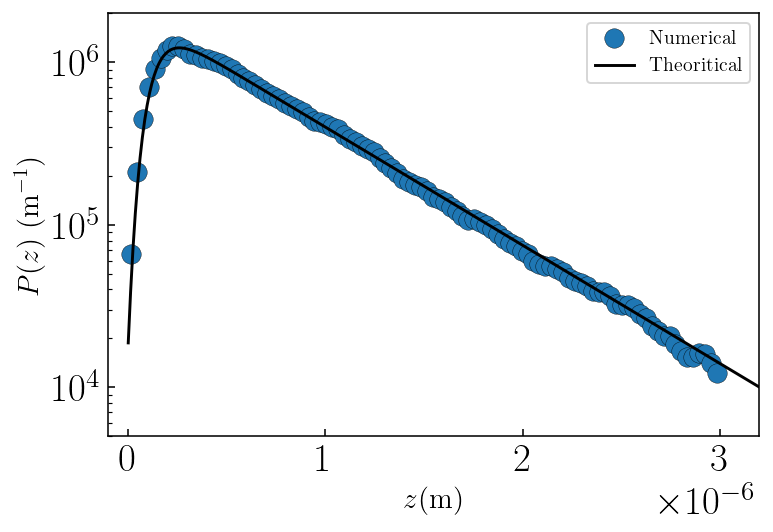

In [6]:
plt.axis([-1e-7, 3.2e-6, 5e3, 2e6])
simu.PDF("z", N_tau=10, space="wall", bins=100, plot=True)

On peut calculer la valeur moyenne des coeficients de diffusion collinaire et transverse à l'aide de $P_\mathrm{eq}(z)$ :
\begin{equation}
    \langle D_i \rangle_z = \int_{-\infty}^{+\infty} D_i ~ P_\mathrm{eq}(z) \mathrm{d}z .
\end{equation}

### 3.b) $P(\Delta x_i, \tau)$, $x_i = \{ x,y,z \}$.

La PDF des déplacement en $x$, $y$ et $z$ sont données par la relation: 


\begin{equation}
    P(\Delta x_i, \tau) = \frac{1}{N} \int_{-\infty}^{+\infty} P(D_i) \exp \left( -\frac{\Delta x_i^2}{4 D_i \tau} \right) ~\mathrm{d}D_i,
\end{equation}
où le déplacement est calculé à partir du retard $\tau$ tel que $\Delta x_i = x_i(t+\tau)-x_i(t)$ et $N$ est le facteur de normalisation.

La PDF des coeficients de disctributioin est donnée par :

\begin{equation}
    P(D_i) = \int_{-\infty}^{+\infty} D_i(z)~ P_\mathrm{eq}(z)~ \mathrm{d}z.
\end{equation}

Lorsque $\tau \rightarrow +\infty$, c'est-à-dire lorsque $\tau \gg \tau_\mathrm{c}$, la PDF des déplacements en $z$ devient :

\begin{equation}
    \lim_{\tau \rightarrow +\infty} P(\Delta z, \tau) = \int_{-\infty}^{+\infty} P_\mathrm{eq}(z+ \Delta z)~ P_\mathrm{eq}(z) ~\mathrm{d}z,
\end{equation}

où $\tau_\mathrm{c}$ est le temps caractéristique pour atteindre l'equilibre thermodynamique et est donnée par :

\begin{equation}
    \tau_\mathrm{c} = \frac{l_\mathrm{B} a}{D_0}.
\end{equation}

$\mathrm{\color{purple}{SOURCE~ :~ thèse~ Maxime, ~page ~90}}$.

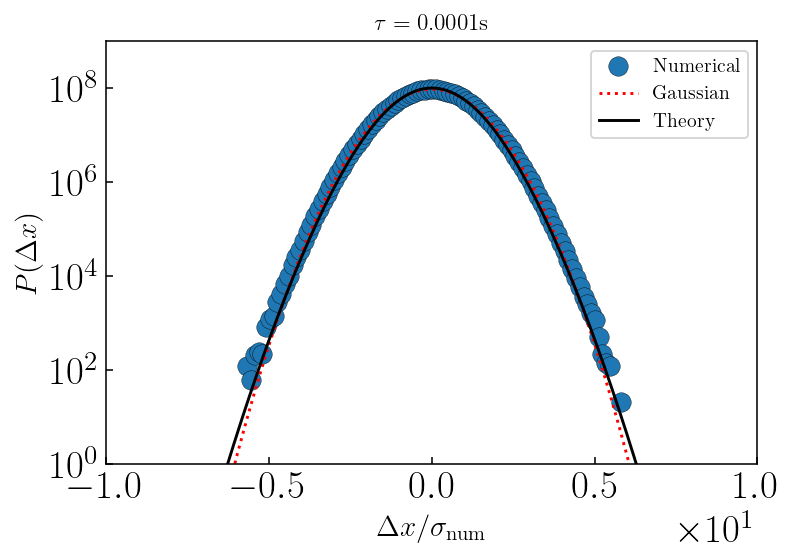

In [7]:
bins = 100
n_tau = 1
plt.axis([-10, 10,1e0, 1e9])
simu.PDF("dx", N_tau=n_tau, space="wall", bins=bins, plot=True)

In [8]:
# plt.axis([-6, 6,1e0, 1e7])
# simu.PDF("dy", N_tau=n_tau, space="wall", bins=100, plot=True)

In [9]:
# plt.axis([-10, 10,1e0, 1e8])
# simu.PDF("dz", N_tau=n_tau, space="wall", bins=100, plot=True)

In [10]:
# plt.axis([-10, 10,0.5e-1, 2e6])
# simu.PDF("dz", N_tau=3000, space="wall", bins=100, plot=True)

## 4. PLot MSD

In [11]:
# simu.MSD(axis="z", space="wall", plot=True, output=False)

## 5. Cumulant ordre 4

Le calcul du cumulant d'ordre $4$ s'effectue à l'aide de la relation :

\begin{equation}
    C^{(4)} = \frac{1}{4!}\left( \langle z(t)-z(t+\tau) \rangle^4 - 3 \langle [z(t)-z(t+\tau)]^2 \rangle^2 \right).
\end{equation}

Théoriquement, au temps court on a :
\begin{equation}
    \lim_{\tau \rightarrow 0}~C^{(4)} = \frac{\tau ^2}{2}\left( \langle D_{\|}^2 \rangle - \langle D_{\|} \rangle^2 \right),
\end{equation}
 et au temps long :
 
\begin{equation}
    \lim_{\tau \rightarrow +\infty}~C^{(4)} = C^{(4)}_0 \tau + C^{(4)}_1.
\end{equation}

 où $C^{(4)}_0$ et $C^{(4)}_1$ sont à determiner numériquement à l'aide du code d'Arthur Alexandre (cf. cumul4.py et note).

100%|███████████████████████████████████████████| 54/54 [01:48<00:00,  2.00s/it]


Pente cumulant4 =  1.177753754710597e-28


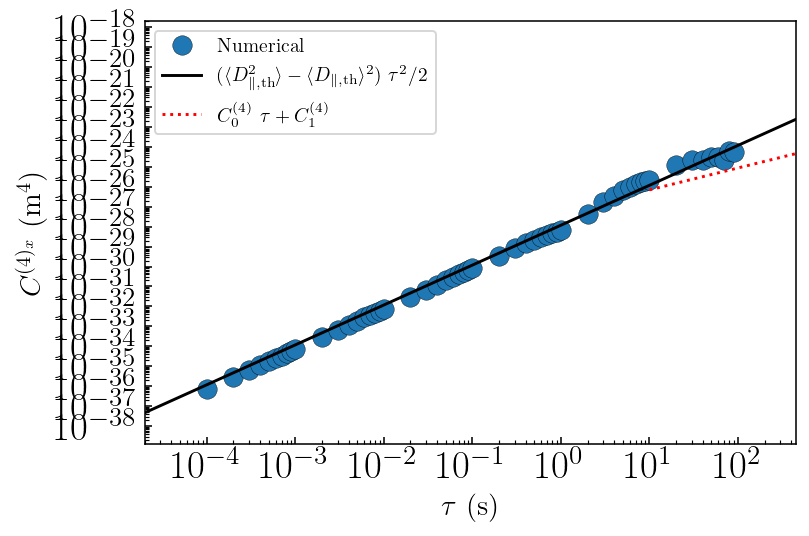

In [12]:
tau, c4, facteur_tempsCourt = simu.Cumulant4(axis="x", plot=True, output=True)

In [13]:
facteur_tempsCourt

1.177753754710597e-28

In [14]:
simu.rho

1050

In [15]:
factoriel4 = 1*2*3*4
facteur_Arthur_tcarré = 1.1062211967574902e-29

tth = np.linspace(5e1, 1e4, 1000)
ttheo = np.linspace(1e-5, 1e1, 100)
C4tempsLong = 1.3530168616502677e-28*tth - 1.0830268045677752e-27
# C4tempsLong

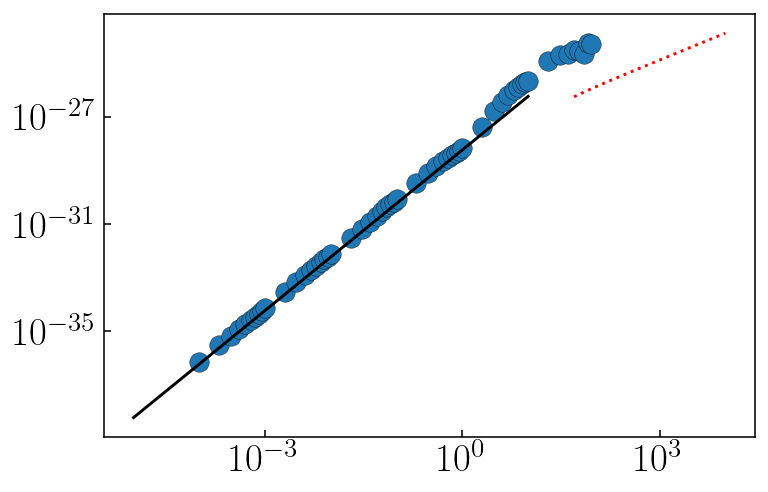

In [24]:
plt.loglog(tau, c4, "o")
plt.loglog(tth, C4tempsLong, "r:")
plt.loglog(ttheo, ttheo**2*facteur_tempsCourt / 2, "-k")
# plt.loglog(ttheo, ttheo**2*facteur_Arthur_tcarré, ":k")

#### $\rightarrow$ Note Emetbrown meeting :

baisser dt (car pb de Euler certainement), laisser Nt

lancer plusoeurs traj (sauvegarde)

plus tard -> subsampling



## Récuperation data dans .mat

In [2]:
def cum4(x, y, list_dt_c4):
    c4 = np.zeros(len(list_dt_c4))
    for k, i in enumerate(list_dt_c4):
                    
        
        deltaX = x[i:] - x[:-i]
        deltaY = y[i:] - y[:-i]

        c4[k] = (
            1
            / (2 * 24)
            * (
                np.mean(deltaX ** 4)
                - 3 * (np.mean(deltaX ** 2)) ** 2
                + np.mean(deltaY ** 4)
                - 3 * (np.mean(deltaY ** 2)) ** 2
            )
        )
    return c4

def hist(data, bins = 100):
    Y, X = np.histogram(data, bins = bins, density=True)
    X = (X[:-1] + X[1:])/2
    return X, Y


In [3]:
from scipy.io import savemat
from multiprocessing import Pool




In [4]:
def uniform():
    return np.random.uniform(1e-12, 10e-6)    

def Peq_z(z, lD, lB):
    p = np.exp(-4.8 * np.exp(-z / lD) - z / lB)
    
    return p

def normalisation_Peq_z(lD, lB):
    z=np.linspace(1e-12, 10e-6, 10000)
    return 1 / np.trapz(Peq_z(z, lD, lB), z)


lD, lB = 70e-9 , 7.96045111217363e-07

A=normalisation_Peq_z(lD, lB)

# mini = np.min(Peq_z(np.linspace(1e-12, 10e6), lD, lB)*A)
# maxi = np.max(Peq_z(np.linspace(1e-12, 10e6), lD, lB)*A)

In [5]:
from scipy.stats import rv_continuous

class PeqZ_gen(rv_continuous):

    "distribution prêt d'un mur dur."

    def _pdf(self, z):
        
        lD, lB = 70e-9 , 7.96045111217363e-07
        if z<0:
            return 0

        return np.exp(-4.8 * np.exp(-z / lD) - z / lB)*A

PeqZ0 = PeqZ_gen(a=0, b=10e-6, name='PeqZ0')

#PeqZ0._pdf(1e-6, A)

In [8]:
from tqdm import trange
a= [PeqZ0.rvs() for i in trange(10000)]

100%|████████████████████████████████████| 10000/10000 [00:18<00:00, 535.39it/s]


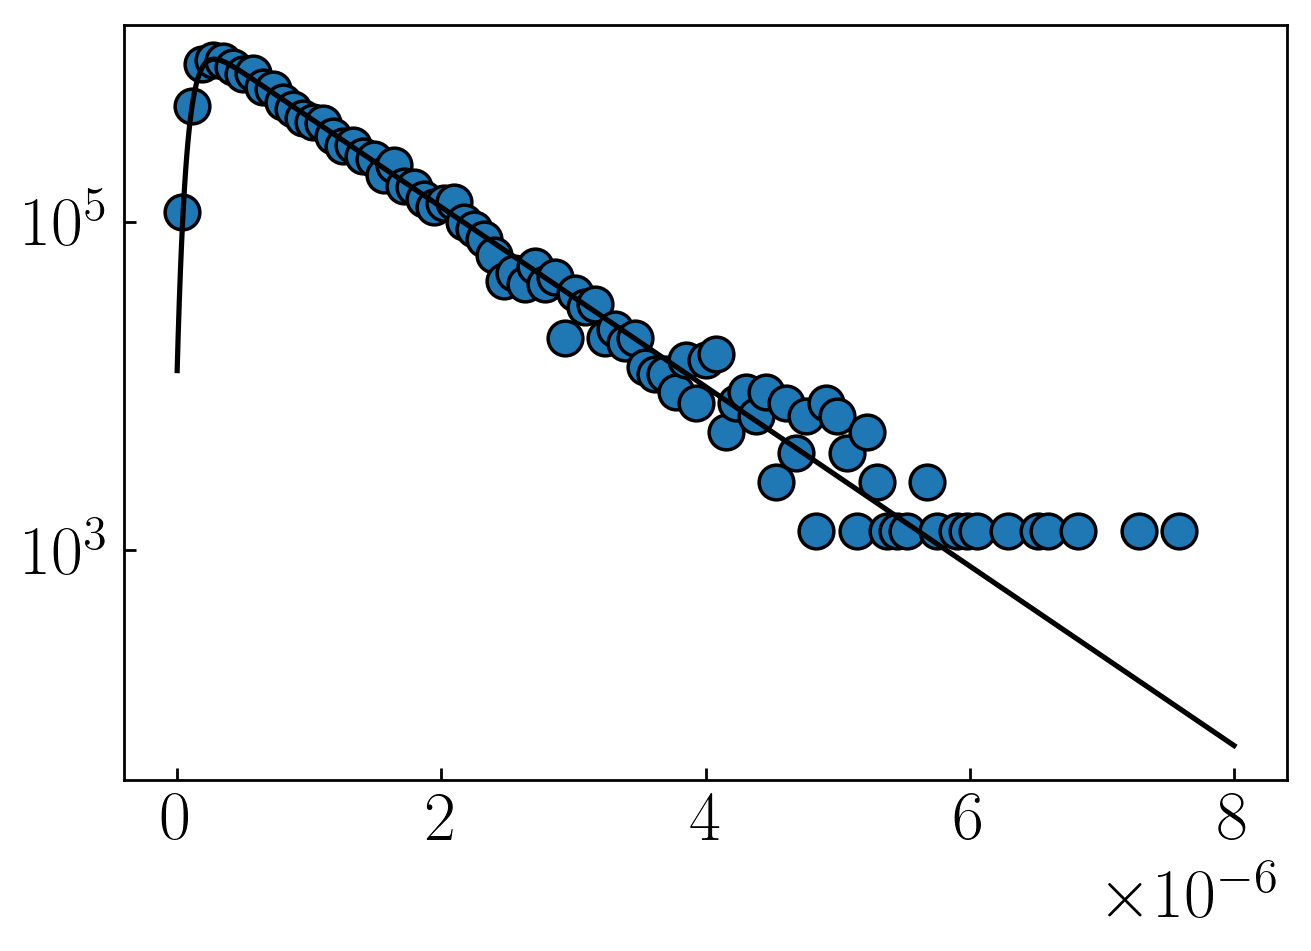

In [9]:
a = np.array(a)
plt.semilogy(*hist(a,bins = 100), "o",)
zz = np.linspace(1e-12, 8e-6, 1000)
plt.plot(zz, Peq_z(zz, lD, lB)*A, color="k")

In [10]:
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
total_tasks = 10
Nt = 100000000
list_dt_c4 = np.array([], dtype=int)
for i in range(len(str(Nt)) - 1):
    # Take just 10 points by decade.        
    list_dt_c4 = np.concatenate(
        (
            list_dt_c4,
            np.arange(10 ** i, 10 ** (i + 1), 10 ** i, dtype=int),
        )
    )

            
def run(i):
    dt = 1e-5
    a = 1.5e-6
    rho = 1050
    r0 = (0., 0., PeqZ0.rvs())
    simu = RigidWallOverdampedLangevin3D(dt=dt, Nt=Nt, R=a, rho=rho, x0=r0)
    simu.trajectory() 
    c4 = cum4(simu.x, simu.y, list_dt_c4)
    return c4
#result = p.imap_unordered(run, [0]*total_tasks)
r = process_map(run, [0]*total_tasks, max_workers=10, chunksize=1)
rr = np.array(r)
dt=1e-5
a = 1.5e-6
rho = 1050


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
data = {}
data["Cumulant4"] = rr
data["tau_C4"] = list_dt_c4*dt
data["rayon"] = a
data["Nt"] = Nt
data["dt"] = dt
data["rho"] = rho
data["rhoF"] = 1000.0
data["NombreTrajectoire"] = total_tasks
data["CodeOrigine"] = "Analyse_Overd-Rigid-Wall-CYTHON(longTraj).ipynb"
data["Description"] = "Overdamped Mur dur + poids. Positions initiale avec PDFeqZ_wall. Resultat du calcul du Cumulant d'ordre 4." 

from scipy.io import savemat
savemat("datas_C4_ntraj"+ str(total_tasks) +"_sim.mat", data)

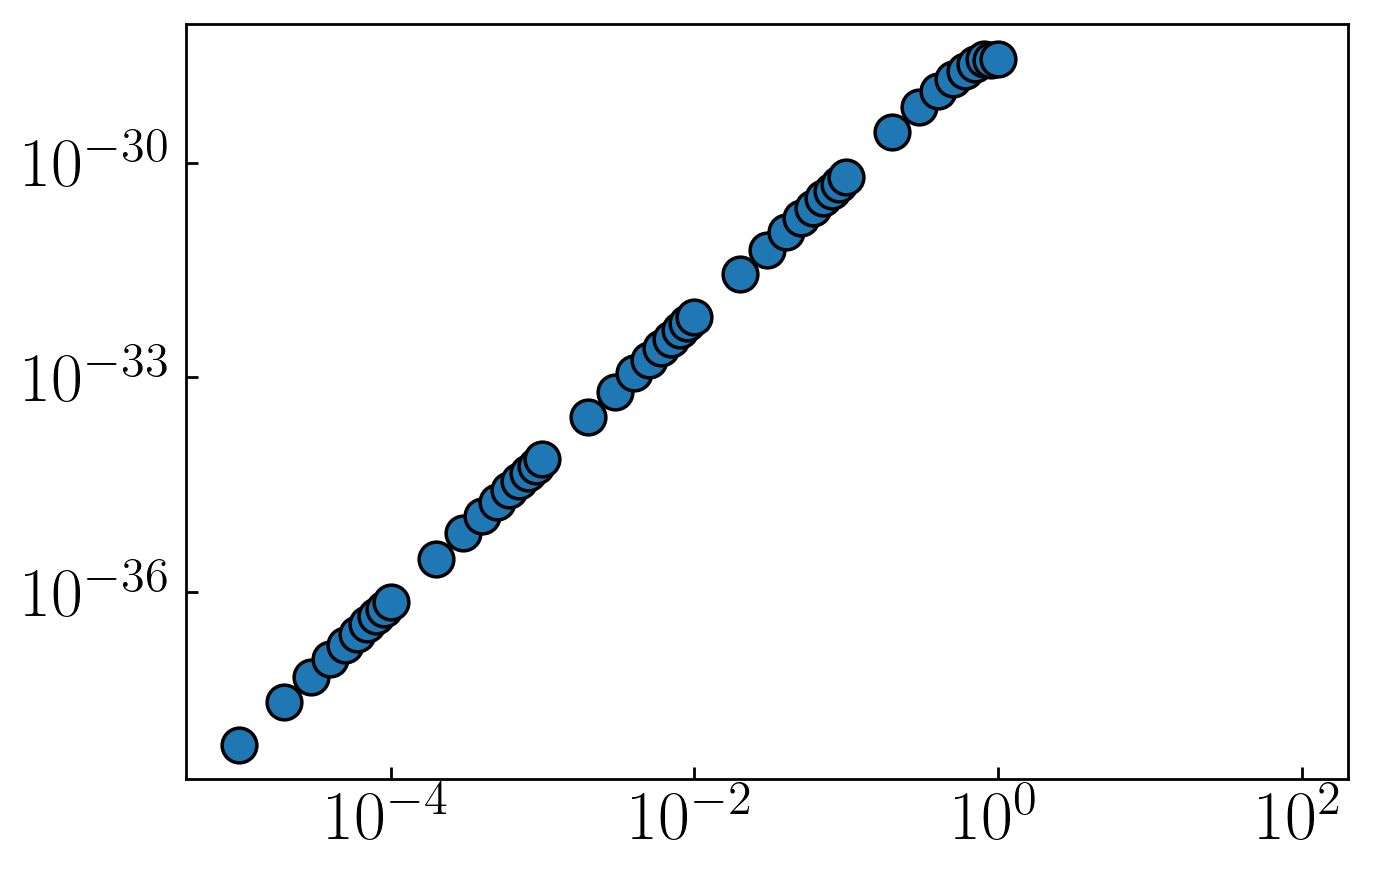

In [80]:
n=7500
#for i in r:
# plt.loglog(list_dt_c4[:n]*1e-3, i[:n],"o")
plt.loglog(list_dt_c4[:]*1e-5, np.mean(r, axis=0)[:], "o")
#plt.xlim(1e-4, None)
#plt.ylim(0,1e-30) 

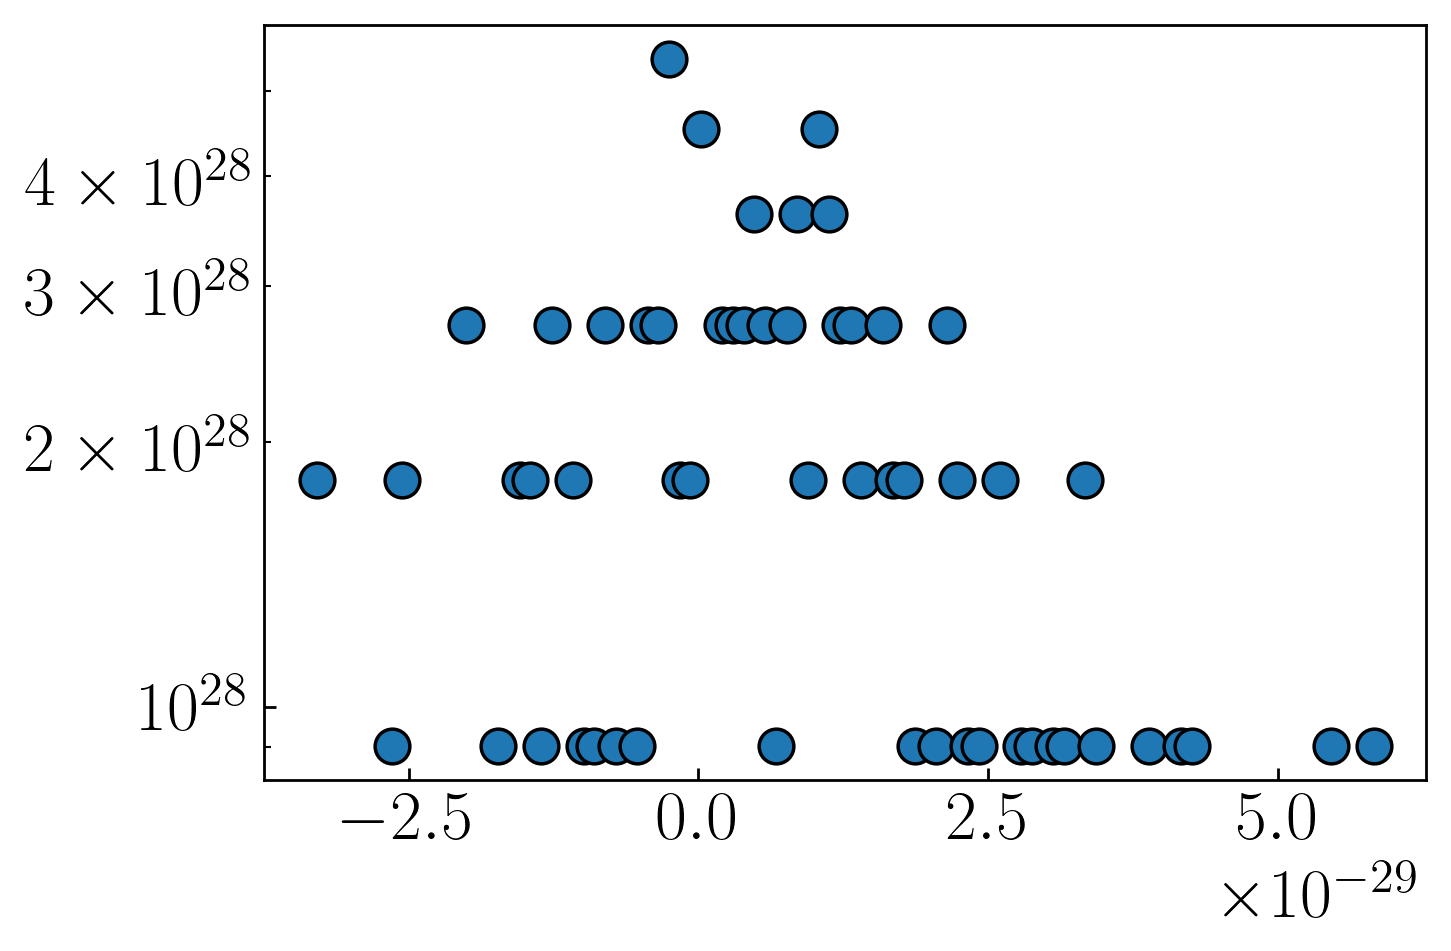

In [74]:

plt.semilogy(*hist(rr[:,38]), "o")

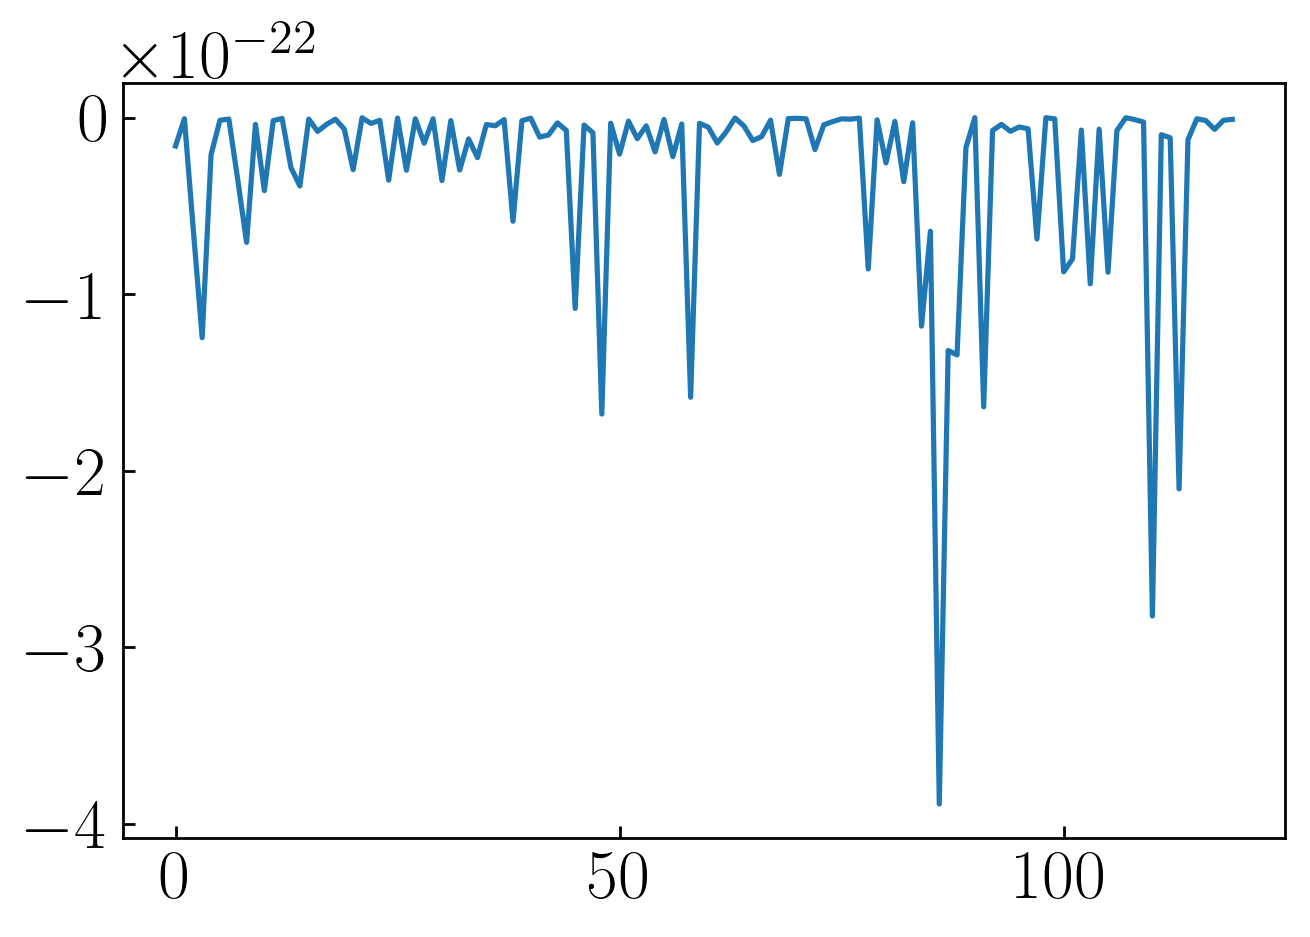

In [75]:
plt.plot(rr[:,60])

In [76]:
def gamma_parallele(z, a, eta):
    xi = a / (z + a)

    gamma_xy = (
        6
        * np.pi
        * a
        * eta
        * (
            1
            - 9/16 * xi
            + 1/8 * xi**3
            - 45/256 * xi**4
            - 1/16 * xi**5
        )
        ** (-1)
    )
    return gamma_xy

def D_parallele(z, a, eta, kB, T):
    return kB*T/gamma_parallele(z, a, eta)

def P_eq_perpendiculaire(z, B, lD, lB):
    if type(z) != np.ndarray:
        if z < 0:
            return 0
        return np.exp(-(B) * np.exp(- z / lD) - z / lB)

    P = np.exp(-(B) * np.exp(- z / lD) - z / lB)
    P[z < 0] = 0
    
    return P

1.177753754710597e-28


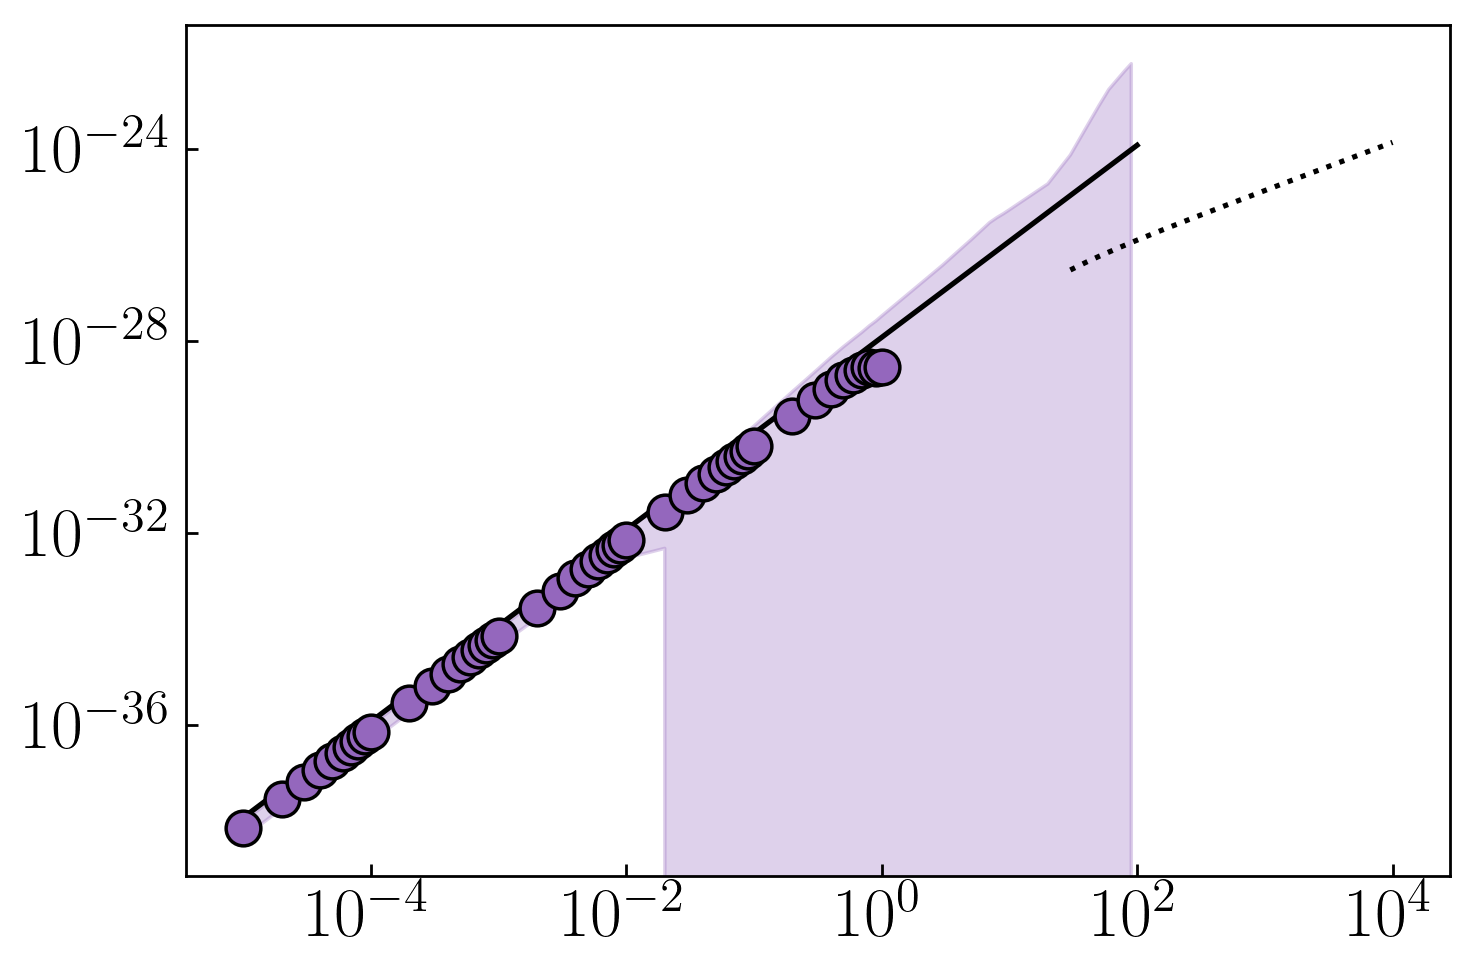

In [87]:
n=38
Nt = 100000000
a = 1.5e-6
rho = 1050
r0 = (0., 0., 1.5e-6) 
eta = 1e-3
T=300
kB = 1.38e-23
lD = 70e-9 
rhoF = 1e3
delta_m = (4 / 3) * np.pi * a**3 * (rho - rhoF)
lB = (kB * T) / (delta_m * 9.81)
zth = np.linspace(1e-12, 10e-6, 30000)

Dx = D_parallele(zth, a, eta, kB, T)
P_eq_z = P_eq_perpendiculaire(zth, 4.8, lD, lB)
P_eq_z = P_eq_z  / np.trapz(P_eq_z, zth)
mean_Dx = np.trapz(Dx*P_eq_z, zth)
mean_Dx2 = np.trapz(Dx**2 * P_eq_z, zth)


tau = 1e-2*list_dt_c4
tth_long = np.linspace(3e1, 1e4, 1000)
tth_court = np.linspace(1e-5, 1e2, 100)
C4tempsLong = 1.3530168616502677e-28*tth_long - 1.0830268045677752e-27
facteur_tempCourt =  (mean_Dx2 - mean_Dx**2) / 2 
C4tempscourt = facteur_tempCourt  * tth_court**2 
print(facteur_tempCourt)

plt.plot(tth_long, C4tempsLong, "k:")
plt.plot(tth_court, C4tempscourt, "k-")

#Plot data

n=200
#for i in result:
    #plt.loglog(list_dt_c4[:n]*1e-4, i[:n],"o", zorder = -1)
plt.loglog(list_dt_c4[:n]*dt, np.mean(r, axis=0)[:n], "o", color = "tab:purple")
plt.fill_between(list_dt_c4[:n]*dt, np.mean(r, axis=0)[:n] - np.std(r, axis=0)[:n], np.mean(r, axis=0)[:n] + np.std(r, axis=0)[:n], alpha = 0.3, color = "tab:purple")
#plt.xlim(1e-4, None)
#plt.ylim(0,1e-30)

#x = plt.gca()
#ocmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
#x.yaxis.set_major_locator(locmaj)
#ocmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
                                      #numticks=100)
#x.yaxis.set_minor_locator(locmin)
#x.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())


#ocmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
#ax.xaxis.set_major_locator(locmaj)
#locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
                                      #numticks=100)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
plt.tight_layout()
#plt.xlim(1e-5,30)
#plt.ylim(1e-36, 1e-25)
plt.show()

1.177753754710597e-28


/tmp/ipykernel_16039/1776218488.py:59: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0,100)


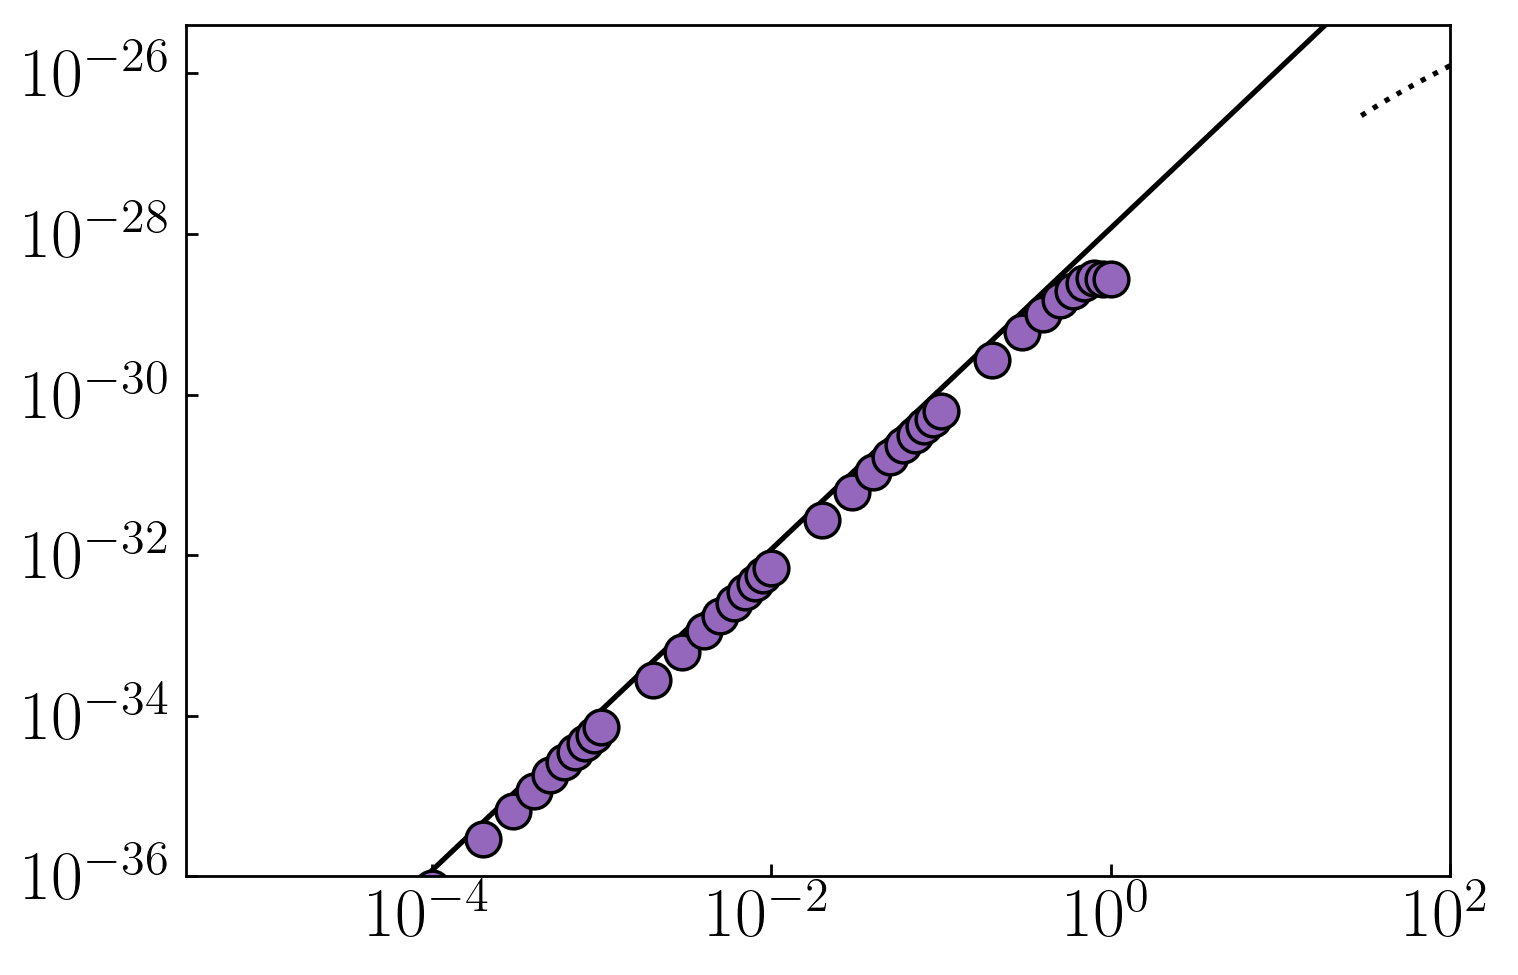

In [86]:
n=38
Nt = 100000000
a = 1.5e-6
rho = 1050
r0 = (0., 0., 1.5e-6) 
eta = 1e-3
T=300
kB = 1.38e-23
lD = 70e-9 
rhoF = 1e3
delta_m = (4 / 3) * np.pi * a**3 * (rho - rhoF)
lB = (kB * T) / (delta_m * 9.81)
zth = np.linspace(1e-12, 10e-6, 30000)

Dx = D_parallele(zth, a, eta, kB, T)
P_eq_z = P_eq_perpendiculaire(zth, 4.8, lD, lB)
P_eq_z = P_eq_z  / np.trapz(P_eq_z, zth)
mean_Dx = np.trapz(Dx*P_eq_z, zth)
mean_Dx2 = np.trapz(Dx**2 * P_eq_z, zth)


tau = 1e-2*list_dt_c4
tth_long = np.linspace(3e1, 1e4, 1000)
tth_court = np.linspace(1e-5, 1e2, 100)
C4tempsLong = 1.3530168616502677e-28*tth_long - 1.0830268045677752e-27
facteur_tempCourt =  (mean_Dx2 - mean_Dx**2) / 2 
C4tempscourt = facteur_tempCourt  * tth_court**2 
print(facteur_tempCourt)

plt.plot(tth_long, C4tempsLong, "k:")
plt.plot(tth_court, C4tempscourt, "k-")

#Plot data

n=200
#for i in result:
    #plt.loglog(list_dt_c4[:n]*1e-4, i[:n],"o", zorder = -1)
plt.loglog(list_dt_c4[:n]*dt, np.mean(r, axis=0)[:n], "o", color = "tab:purple")
#plt.fill_between(list_dt_c4[:n]*1e-3, np.mean(r, axis=0)[:n] - np.std(r, axis=0)[:n], np.mean(r, axis=0)[:n] + np.std(r, axis=0)[:n], alpha = 0.3, color = "tab:purple")
#plt.xlim(1e-4, None)
#plt.ylim(0,1e-30)

#x = plt.gca()
#ocmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
#x.yaxis.set_major_locator(locmaj)
#ocmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
                                      #numticks=100)
#x.yaxis.set_minor_locator(locmin)
#x.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())


#ocmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
#ax.xaxis.set_major_locator(locmaj)
#locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
                                      #numticks=100)
#ax.xaxis.set_minor_locator(locmin)
#ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
plt.tight_layout()
plt.xlim(0,100)
plt.ylim(1e-36, 4e-26)
plt.show()

In [85]:
# data = {}
# data["c4"] = rr
# data["t_c4"] = list_dt_c4*1e-3

# from scipy.io import savemat
# savemat("data_c4_6500_sim1.mat", data)